In [1]:
!pip install qiskit
!pip install qiskit-aer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 34.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 47.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 100.2 MB/s eta 0:00:00


In [2]:
# Deutsch Algorithm using Qiskit 2.x
# Compatible with Qiskit 2.0+ (2024–2025)

from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Statevector
from qiskit_aer import AerSimulator

# Choose the function type: 'constant_0', 'constant_1', 'balanced_0', 'balanced_1'
function_type = 'balanced_1'

def deutsch_oracle(qc, function_type):
    """Implements oracle Uf for given function type."""
    if function_type == 'constant_0':
        # f(x)=0 → Do nothing
        pass
    elif function_type == 'constant_1':
        # f(x)=1 → Apply X on the output qubit
        qc.x(1)
    elif function_type == 'balanced_0':
        # f(x)=x → Apply CNOT (control: input, target: output)
        qc.cx(0, 1)
    elif function_type == 'balanced_1':
        # f(x)=NOT(x) → Apply X, then CNOT, then X
        qc.x(0)
        qc.cx(0, 1)
        qc.x(0)

In [3]:
# Step 1: Initialize quantum circuit with 2 qubits and 1 classical bit
qc = QuantumCircuit(2, 1)

# Step 2: Initialize |x>|y> = |0>|1> and apply Hadamard
qc.x(1)             # Set output qubit to |1>
qc.barrier()
qc.h([0, 1])        # Apply Hadamard to both qubits

# Step 3: Apply the oracle
qc.barrier()
deutsch_oracle(qc, function_type)

In [4]:
# Step 4: Apply Hadamard to input qubit
qc.barrier()
qc.h(0)

# Step 5: Measure the first qubit
qc.measure(0, 0)

# Visualize circuit
print(qc.draw(output="text"))

           ░ ┌───┐ ░ ┌───┐     ┌───┐ ░ ┌───┐┌─┐
q_0: ──────░─┤ H ├─░─┤ X ├──■──┤ X ├─░─┤ H ├┤M├
     ┌───┐ ░ ├───┤ ░ └───┘┌─┴─┐└───┘ ░ └───┘└╥┘
q_1: ┤ X ├─░─┤ H ├─░──────┤ X ├──────░───────╫─
     └───┘ ░ └───┘ ░      └───┘      ░       ║ 
c: 1/════════════════════════════════════════╩═
                                             0 


In [5]:
# Step 6: Simulate
sim = AerSimulator()
qc_compiled = transpile(qc, sim)
result = sim.run(qc_compiled).result()
counts = result.get_counts()

print("\nMeasurement results:", counts)

# Interpret result
if list(counts.keys())[0] == '0':
    print("→ Function is CONSTANT.")
else:
    print("→ Function is BALANCED.")


Measurement results: {'1': 1024}
→ Function is BALANCED.


**Tasks**

In [6]:
#task 1
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator

def oracle_xor1(qc: QuantumCircuit):
    """Implements Uf for f(x)=x⊕1 (i.e., NOT(x))."""
    # Same as your 'balanced_1': flip input, CNOT, unflip input
    qc.x(0)
    qc.cx(0, 1)
    qc.x(0)

def deutsch_run(oracle_fn):
    qc = QuantumCircuit(2, 1)
    qc.x(1)        # |y> = |1>
    qc.h([0, 1])   # H on both
    oracle_fn(qc)  # Uf
    qc.h(0)        # Interference on input
    qc.measure(0, 0)
    sim = AerSimulator()
    res = sim.run(transpile(qc, sim), shots=2048).result().get_counts()
    print(qc.draw("text"))
    print("Counts:", res)
    print("→ Function is", "BALANCED" if max(res, key=res.get) == '1' else "CONSTANT")

deutsch_run(oracle_xor1)


     ┌───┐┌───┐     ┌───┐┌───┐┌─┐
q_0: ┤ H ├┤ X ├──■──┤ X ├┤ H ├┤M├
     ├───┤├───┤┌─┴─┐└───┘└───┘└╥┘
q_1: ┤ X ├┤ H ├┤ X ├───────────╫─
     └───┘└───┘└───┘           ║ 
c: 1/══════════════════════════╩═
                               0 
Counts: {'1': 2048}
→ Function is BALANCED


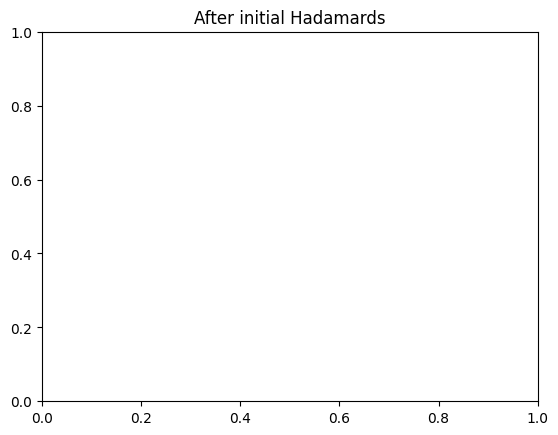

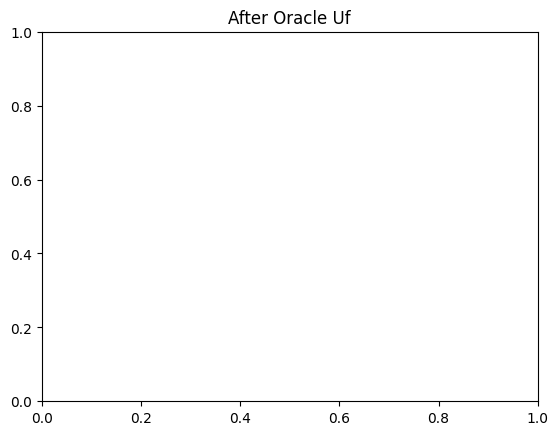

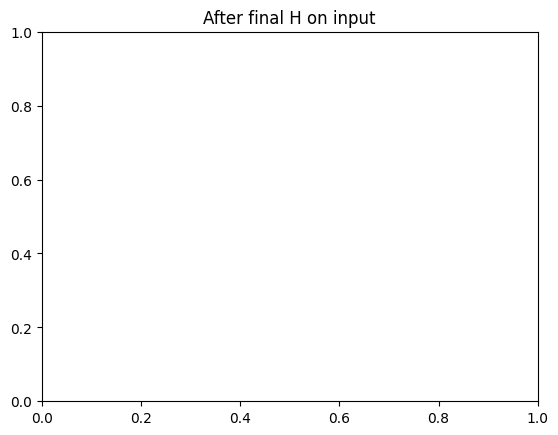

In [7]:
# Task 2: Bloch Sphere Visualization (after H, after Uf)

from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_bloch_multivector
import matplotlib.pyplot as plt

def deutsch_states_for_bloch(oracle_fn):
    # Build stage-by-stage circuits for state capture
    base = QuantumCircuit(2)
    base.x(1)          # |0⟩|1⟩
    # After first H layer
    after_H = base.copy()
    after_H.h([0, 1])
    sv_after_H = Statevector.from_instruction(after_H)

    # After oracle
    after_U = after_H.copy()
    oracle_fn(after_U)
    sv_after_U = Statevector.from_instruction(after_U)

    # Optionally after final H on input:
    after_final_H = after_U.copy()
    after_final_H.h(0)
    sv_after_final_H = Statevector.from_instruction(after_final_H)

    return sv_after_H, sv_after_U, sv_after_final_H

sv_H, sv_U, sv_final = deutsch_states_for_bloch(oracle_xor1)

# Bloch vectors (one sphere per qubit; partial trace handled automatically)
plot_bloch_multivector(sv_H);     plt.title("After initial Hadamards"); plt.show()
plot_bloch_multivector(sv_U);     plt.title("After Oracle Uf");         plt.show()
plot_bloch_multivector(sv_final); plt.title("After final H on input");  plt.show()


In [8]:
# task 3:Deutsch–Jozsa (n=2 inputs)

from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator

def dj_oracle(qc: QuantumCircuit, oracle_type="balanced_parity"):
    """
    Two input qubits (q0, q1) + one ancilla/output (q2).
    oracle_type ∈ {"constant_0","constant_1","balanced_parity"}
    """
    if oracle_type == "constant_0":
        # f(x)=0 ⇒ do nothing
        pass
    elif oracle_type == "constant_1":
        # f(x)=1 ⇒ flip ancilla
        qc.x(2)
    elif oracle_type == "balanced_parity":
        # f(x)=x0⊕x1 ⇒ ancilla ^= x0, ancilla ^= x1
        qc.cx(0, 2)
        qc.cx(1, 2)
    else:
        raise ValueError("Unknown oracle_type")

def deutsch_jozsa_n2(oracle_type="balanced_parity", shots=2048):
    qc = QuantumCircuit(3, 2)  # 2 inputs, 1 ancilla, measure only inputs
    # |x>=|00>, |y>=|1>
    qc.x(2)
    # H on all three
    qc.h([0, 1, 2])
    # Uf
    dj_oracle(qc, oracle_type)
    # H on inputs only
    qc.h([0, 1])
    # Measure inputs
    qc.measure([0, 1], [0, 1])

    sim = AerSimulator()
    counts = sim.run(transpile(qc, sim), shots=shots).result().get_counts()
    print(qc.draw("text"))
    print("Counts:", counts)
    is_constant = max(counts, key=counts.get) == '00'
    print("→ Function is", "CONSTANT" if is_constant else "BALANCED")

deutsch_jozsa_n2("balanced_parity")
deutsch_jozsa_n2("constant_0")
deutsch_jozsa_n2("constant_1")


     ┌───┐          ┌───┐     ┌─┐   
q_0: ┤ H ├───────■──┤ H ├─────┤M├───
     ├───┤       │  └───┘┌───┐└╥┘┌─┐
q_1: ┤ H ├───────┼────■──┤ H ├─╫─┤M├
     ├───┤┌───┐┌─┴─┐┌─┴─┐└───┘ ║ └╥┘
q_2: ┤ X ├┤ H ├┤ X ├┤ X ├──────╫──╫─
     └───┘└───┘└───┘└───┘      ║  ║ 
c: 2/══════════════════════════╩══╩═
                               0  1 
Counts: {'11': 2048}
→ Function is BALANCED
     ┌───┐┌───┐┌─┐   
q_0: ┤ H ├┤ H ├┤M├───
     ├───┤├───┤└╥┘┌─┐
q_1: ┤ H ├┤ H ├─╫─┤M├
     ├───┤├───┤ ║ └╥┘
q_2: ┤ X ├┤ H ├─╫──╫─
     └───┘└───┘ ║  ║ 
c: 2/═══════════╩══╩═
                0  1 
Counts: {'00': 2048}
→ Function is CONSTANT
     ┌───┐┌───┐     ┌─┐   
q_0: ┤ H ├┤ H ├─────┤M├───
     ├───┤├───┤     └╥┘┌─┐
q_1: ┤ H ├┤ H ├──────╫─┤M├
     ├───┤├───┤┌───┐ ║ └╥┘
q_2: ┤ X ├┤ H ├┤ X ├─╫──╫─
     └───┘└───┘└───┘ ║  ║ 
c: 2/════════════════╩══╩═
                     0  1 
Counts: {'00': 2048}
→ Function is CONSTANT


In [9]:
# task 4 : Noise Impact (Aer noise model)

from qiskit_aer.noise import NoiseModel, depolarizing_error, ReadoutError

def make_simple_noise_model(p1=0.003, p2=0.02, ro=[[0.97,0.03],[0.05,0.95]]):
    nm = NoiseModel()
    # 1q depolarizing on common 1q ops
    nm.add_all_qubit_quantum_error(depolarizing_error(p1, 1), ['x','h','sx'])
    # 2q depolarizing on CX
    nm.add_all_qubit_quantum_error(depolarizing_error(p2, 2), ['cx'])
    # Readout error
    nm.add_all_qubit_readout_error(ReadoutError(ro))
    return nm

def run_with_and_without_noise(build_circuit_callable, shots=4096):
    # build circuit
    qc = build_circuit_callable()
    # ideal
    sim_ideal = AerSimulator()
    counts_ideal = sim_ideal.run(transpile(qc, sim_ideal), shots=shots).result().get_counts()
    # noisy
    noise_model = make_simple_noise_model()
    sim_noisy = AerSimulator(noise_model=noise_model)
    counts_noisy = sim_noisy.run(transpile(qc, sim_noisy), shots=shots).result().get_counts()
    return qc, counts_ideal, counts_noisy

# Example: test on Deutsch with f(x)=x⊕1
def build_deutsch_xor1():
    qc = QuantumCircuit(2, 1)
    qc.x(1); qc.h([0,1]); oracle_xor1(qc); qc.h(0); qc.measure(0,0)
    return qc

qc, ideal, noisy = run_with_and_without_noise(build_deutsch_xor1)
print(qc.draw("text"))
print("Ideal counts:", ideal)
print("Noisy counts:", noisy)
print("Ideal decision:", "BALANCED" if max(ideal, key=ideal.get)=='1' else "CONSTANT")
print("Noisy decision:", "BALANCED" if max(noisy, key=noisy.get)=='1' else "CONSTANT")


     ┌───┐┌───┐     ┌───┐┌───┐┌─┐
q_0: ┤ H ├┤ X ├──■──┤ X ├┤ H ├┤M├
     ├───┤├───┤┌─┴─┐└───┘└───┘└╥┘
q_1: ┤ X ├┤ H ├┤ X ├───────────╫─
     └───┘└───┘└───┘           ║ 
c: 1/══════════════════════════╩═
                               0 
Ideal counts: {'1': 4096}
Noisy counts: {'0': 292, '1': 3804}
Ideal decision: BALANCED
Noisy decision: BALANCED


In [10]:
# task 5:  Classical vs Quantum Queries (query counting)

import random

# Define classical oracle functions on {0,1}
def f_constant_0(x): return 0
def f_constant_1(x): return 1
def f_balanced_0(x): return x
def f_balanced_1(x): return 1 - x

FUNCTIONS = {
    "constant_0": f_constant_0,
    "constant_1": f_constant_1,
    "balanced_0": f_balanced_0,
    "balanced_1": f_balanced_1
}

def classify_classical(f):
    # Query f(0); if 0, need f(1) to be sure; if 1, same.
    q = 0
    v0 = f(0); q += 1
    # If we *assume* constant after one query, we risk error;
    # to be certain, we must query x=1 too.
    v1 = f(1); q += 1
    is_const = (v0 == v1)
    return ("CONSTANT" if is_const else "BALANCED"), q

def classify_quantum_query_count():
    # Deutsch always 1 oracle call
    return "1 query"

# Demo comparison over all 4 Deutsch functions
for name, f in FUNCTIONS.items():
    cls, q = classify_classical(f)
    print(f"{name:12s}: classical={cls:9s} in {q} queries; quantum: {classify_quantum_query_count()}")


constant_0  : classical=CONSTANT  in 2 queries; quantum: 1 query
constant_1  : classical=CONSTANT  in 2 queries; quantum: 1 query
balanced_0  : classical=BALANCED  in 2 queries; quantum: 1 query
balanced_1  : classical=BALANCED  in 2 queries; quantum: 1 query
